# Setup and reading in data:

+ split data into test and train with sklearn 
+ test models with sklearn.metrics accuracy_score
+ R2 score for simplest model (horizontal line), RMSE should be way worse for that than the linear fit model. sklearn.metris r2_score



+ report r2 and mse for all models test and train
+ show under/over fit. 
+ lr, svm, decisions tree/random forest, boosting. knn to show over/underfitt  

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
# Others here as needed;

In [2]:
# "globals" -- bounding edges of crime in Chicago
lat_min = 41.644604096
lat_max = 42.022671246
lon_min = -87.928909442 
lon_max = -87.524529378

In [3]:
# Read in new da
vacant_df = pd.read_csv("data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv")
health_df = pd.read_csv("data/Chicago_Department_of_Public_Health_Clinic_Locations.csv")
connect_df = pd.read_csv("data/Connect_Chicago_Locations.csv") # internet access
bus_df = pd.read_csv("data/CTA_-_System_Information_-_Bus_Stop_Locations_in_Digital_Sign_Project.csv")
train_df = pd.read_csv("data/CTA_-_System_Information_-_List_of__L__Stops.csv")
farmer_df = pd.read_csv("data/Farmers_Markets_-_2012.csv")
library_df = pd.read_csv("data/Libraries_-_Locations__Hours_and_Contact_Information.csv")
police_df = pd.read_csv("data/Police_Stations_Map.csv")
crime_df = pd.read_csv("data/Chicago_Crimes_2012_to_2017.csv")

/Users/jacob/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Crime dataset is quite large, so we'll only focus on last year:
crime_df = crime_df[crime_df["Year"] == 2016]

# Convert the string dates to datetime objects
crime_df["Date"] = pd.to_datetime(crime_df["Date"])

In [5]:
# Let's add a column that is 0-366 range, this will allow us to look at time slices throughout 2016
crime_df["Day"] = crime_df["Date"].apply(lambda x: x.timetuple().tm_yday)

In [6]:
def location_converter(s):
    """Takes a series of points -- tuples (lat, lon) --  as strings and converts them to floats"""
    return s.apply(lambda x: tuple(float(x) for x in x.strip(')(').replace(',','').split()))

# Not all DFs had the same keyname for the lat/lon points. Now they'll all be converted
# in to simple series of tuples. 
vacant_locations = location_converter(vacant_df["Location"].dropna())
health_locations = location_converter(health_df["Location"].dropna())
connect_locations = location_converter(connect_df["Location"].dropna())
bus_locations = location_converter(bus_df["Location"].dropna())
train_locations = location_converter(train_df["Location"].dropna())
farmer_locations = location_converter(farmer_df["Map"].dropna())
library_locations = location_converter(library_df["LOCATION"].dropna())
police_locations = location_converter(police_df["LOCATION"].dropna())

In [7]:
crime_week_df = crime_df[(crime_df["Day"] >= 100) & (crime_df["Day"] <= 107)]
crime_week_locations = location_converter(crime_week_df["Location"].dropna())

In [8]:
def make_grid(m1, m2, bandwidth):
    """ Returns a 200 x 200 grid of the chica"""
    X, Y = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j] # make a mesh grid of the values 100 x 100
    # this grid is from min to max with nj being the step size.  X/Y are 30x30 for the steps between min and max

    positions = np.vstack([X.ravel(), Y.ravel()]) # x row vector on top of y row vector, complete space
    values = np.vstack([m1, m2]) # raw data lat/lon for 23 stations
    kernel = stats.gaussian_kde(values, bw_method=bandwidth)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [9]:
vacant_grid = make_grid([lat for lat,_ in vacant_locations], [lon for _,lon in vacant_locations], 0.26)
health_grid = make_grid([lat for lat,_ in health_locations], [lon for _,lon in health_locations], 0.26)
connect_grid = make_grid([lat for lat,_ in connect_locations], [lon for _,lon in connect_locations], 0.26)
bus_grid = make_grid([lat for lat,_ in bus_locations], [lon for _,lon in bus_locations], 0.26)
train_grid = make_grid([lat for lat,_ in train_locations], [lon for _,lon in train_locations], 0.26)
farmer_grid = make_grid([lat for lat,_ in farmer_locations], [lon for _,lon in farmer_locations], 0.26)
library_grid = make_grid([lat for lat,_ in library_locations], [lon for _,lon in library_locations], 0.26)
police_grid = make_grid([lat for lat,_ in police_locations], [lon for _,lon in police_locations], 0.26)
crime_week_grid = make_grid([lat for lat,_ in crime_week_locations], [lon for _,lon in crime_week_locations], 0.26)

In [10]:
def plot_grid(grid, locations):
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(grid), cmap=plt.cm.gist_earth_r, extent=[lat_min, lat_max, lon_min, lon_max])
    ax.plot([lat for lat,_ in locations], [lon for _,lon in locations], 'k.', markersize=3)
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([lon_min, lon_max])
    plt.show()

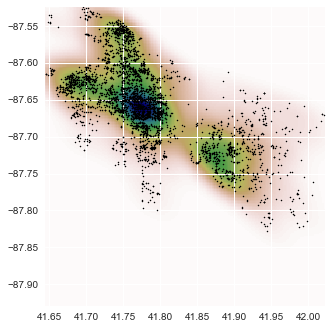

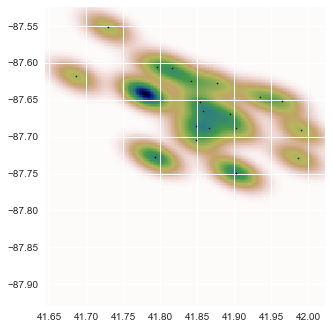

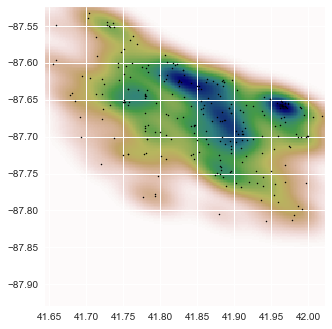

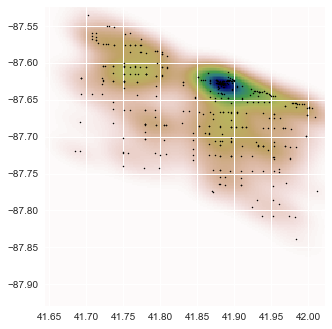

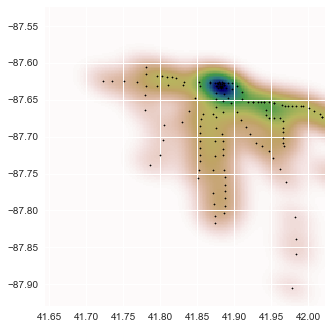

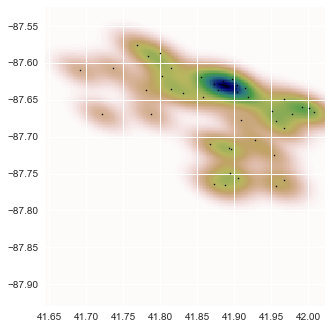

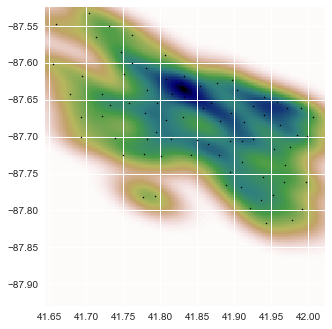

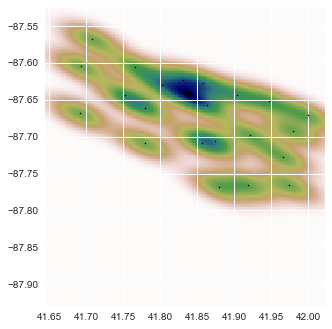

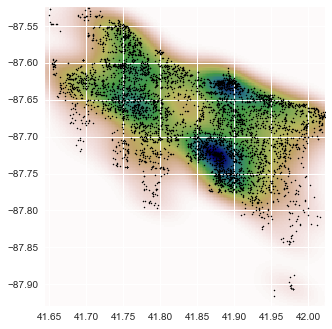

In [11]:
plot_grid(vacant_grid, vacant_locations[:4000]) # too many vacant lots to show all, good LABEL
plot_grid(health_grid, health_locations)
plot_grid(connect_grid, connect_locations)
plot_grid(bus_grid, bus_locations)
plot_grid(train_grid, train_locations)
plot_grid(farmer_grid, farmer_locations)
plot_grid(library_grid, library_locations)
plot_grid(police_grid, police_locations)
plot_grid(crime_week_grid, crime_week_locations)

In [12]:
# Turn the grids into vectors:
vacant_vector = vacant_grid.flatten()
health_vector = health_grid.flatten()
connect_vector = connect_grid.flatten()
bus_vector = bus_grid.flatten()
train_vector = train_grid.flatten()
farmer_vector = farmer_grid.flatten()
library_vector = library_grid.flatten()
police_vector = police_grid.flatten()
crime_week_vector = crime_week_grid.flatten()

# Make a dataframe with the flattened vectors for input to ML algorithms:
grid_df = pd.DataFrame({"Vacant lots" : vacant_vector, "Health clinics" : health_vector, 
                        "Connect hotspots": connect_vector, "Bus stops" : bus_vector, 
                        "Train stops" : train_vector, "Farmers markets": farmer_vector, 
                        "Libraries": library_vector, "Police stations": police_vector})

Pair wise correalation show how much certain variables explain info, if two features have a high r2 score they more or less explain the data in the same way. 
multi colinearity. 

In [13]:
# Slooow: sub sample data to make it faster.
#g = sns.pairplot(grid_df, kind="reg")

In [14]:
#plt.show(g)

# Fitting models

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix # For comparisons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [73]:
# Get test and training sets 20% saved for testing:
X_train, X_test, y_train, y_test = train_test_split(grid_df, crime_week_vector, test_size=0.2) 

In [17]:
#X_test["Police stations"].shape
X_test["Police stations"].values.shape

(8000,)

## Create a baseline by performing regression with Police stations as the only feature:

In [18]:
base_linear_reg = LinearRegression()
base_linear_reg.fit(X_train["Police stations"].values.reshape(-1, 1), y_train)
base_linear_guesses = base_linear_reg.predict(X_test["Police stations"].values.reshape(-1,1))
base_linear_error = mean_squared_error(y_test, base_linear_guesses)
base_linear_r2 = r2_score(y_test, base_linear_guesses)
base_linear_error, base_linear_r2

(35.484607392875986, 0.56369596231929453)

In [38]:
# Performance on the training data:
base_train_guesses = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1, 1))
base_train_error = mean_squared_error(y_test, base_train_guesses[:8000])
base_train_r2 = r2_score(y_test, base_train_guesses[:8000])
base_train_error, base_train_r2

(123.73490468788681, -0.52139314716500706)

## Linear regression with multiple features:

In [20]:
# Linear regression:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_guesses = linear_reg.predict(X_test)
linear_error = mean_squared_error(y_test, linear_guesses)
linear_r2 = r2_score(y_test, linear_guesses)

In [21]:
linear_error, linear_r2 # R2 is in units of the dependant variable. 

(4.5476086172112584, 0.94408448769031095)

Adjusted r2, aic, adjusted criteria. Need the holdout test set to help show this. 

## SVM:

In [22]:
from sklearn.svm import SVR
# The following are used to 
from sklearn import preprocessing
from sklearn import utils

In [23]:
y_train.shape # 32000,
X_train.shape # 32000, 8

(32000, 8)

In [24]:
svr = SVR(kernel='linear') # Why the use of a linear kernel? regression trends support this?

# Properly label encode the float values:
label_encoder = preprocessing.LabelEncoder()
X_train_encoded = X_train.apply(label_encoder.fit_transform) # Must apply to every column
#y_train_encoded = y_train.apply(label_encoder.fit_transform)

#svr.fit(X_train_encoded, y_train_encoded)

In [25]:
y_train_encoded = label_encoder.fit_transform(y_train)

In [26]:
svr.fit(X_train_encoded[1:1000], y_train_encoded[1:1000])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [52]:
svm_guesses = svr.predict(X_test) # Does this need to be encoded?
svm_train_guesses = svr.predict(X_train)

In [64]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
y_test.shape, svm_guesses.shape

((8000,), (8000,))

In [75]:
svm_score = r2_score(svm_guesses, y_test)
svm_train_score = r2_score(svm_train_guesses, y_train)
svm_score, svm_train_score

(-2315.891274567934, -2357.9457532226861)

In [76]:
svm_train_score = svr.score(X_train, y_train)
svm_test_score = svr.score(X_test, y_test)
svm_train_score, svm_test_score

(-2674.7032608209834, -2611.6946234009743)

In [77]:
svm_test_mse = mean_squared_error(svm_guesses, y_test)
svm_train_mse = mean_squared_error(svm_train_guesses, y_train)
svm_test_mse, svm_train_mse

(216785.1840196666, 216744.46900459434)

# Decision Trees:
leaf size, make plot of model complexity from singular leaf(avg) to overfit (leaf for every observation).
max depth leaf

In [121]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)


In [111]:
regr_1.score(X_test, y_test.reshape(-1,1))

0.83726077238189045

In [112]:
regr_2.score(X_test, y_test.reshape(-1,1))

0.95317775268893856

In [123]:
regr_2.score(X_train, y_train)

0.95177853136031487

In [122]:
regr_1.score(X_train, y_train)

0.84474521802898861

In [128]:
mean_squared_error(y_test, y_2)

3.8808841059461385

# Boosting:

In [129]:
from sklearn.ensemble import AdaBoostRegressor

In [142]:
ada_regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)

Max depth of 5 chosen from the above decision tree section as we know it will perform pretty well. 

In [143]:
ada_regr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None)

In [144]:
ada_regr.score(X_test, y_test)

0.9789818142598381